In [48]:
from xclim import ensembles
from pathlib import Path
import xarray as xr
from CMIP6_IO import CMIP6_IO
import os
from dask.distributed import Client
import dask

## Create ensemble files from running CMIP6_light.py
This script will loop over all files found in a speficic folder `lightpath`and find files of teh same variable and scenario to create ensemble files from. The various variables to create ensembles for include `["uvb_","uv_","uvi_","par_", "uvb_", "uva_"]`.

The output is stored under folder `ensemble_path` and the results are used to create the final plots of modeled lightlyfor the paper using notebooks `CMIP6_plot_light_results.ipynb`.


In [49]:
# Define what models, scenarios, and variables to calculate ensemble files from

source_ids = ["CanESM5", "MPI-ESM1-2-LR", "UKESM1-0-LL"]  # , "MPI-ESM1-2-HR"]

# Weights file is created using CMIP6_create_weights.ipynb together with
# the ClimWIP package. The weights are calculated for variable tos using ERSSTv5 and WOA18 as observations
# to compare with. The weights are calculated for the period 1993-2020.
weights_file = "data/Calculated_weights_26092023.nc"

create_ensemble = True
scenarios = ["ssp585"]
var_names = [
    "par_",
    "uvb_",
    "uv_",
    "uvi_",
    "uva_",
    "uv_srf_",
]  # ,"_tos.nc","_siconc.nc"]
var_names = ["uv_", "uvi_", "uva_"]
var_names = ["uvb_"]  # , "_tos.nc","_siconc.nc"]
var_names = ["par", "tos", "uvb", "uv", "uvi", "uva"]  # , "_tos.nc","_siconc.nc"]

percentiles = [2.5, 50.0, 97.5]

create_ensemble_files = True
io = CMIP6_IO()

In [50]:
import numpy as np


def get_weights(weights_file: str, f: str):
    weights = xr.open_dataset(weights_file)

    weights = weights["weights"]
    models = weights["model_ensemble"]
    for source_id in source_ids:
        if source_id in f:
            for d, w in zip(models.values, weights.values):
                if source_id in d.split("_")[0]:
                    print(f"Found model in models {source_id} here {d} weight {w}")
                    return w


def create_ensemble_files(scenarios, var_names):
    max_models = 300
    only_ens = True
    for use_weights in [False]:  # , False]:
        for var_name in var_names:
            for scenario in scenarios:
                counter = 0
                ds_list = []
                ensemble_stats = None
                ensemble_perc = None
                if var_name not in ["tos"]:
                    lightpath = "light/ncfiles"
                    ensemble_path = "light/ncfiles/ensemble"
                else:
                    lightpath = f"light/{scenario}"
                    ensemble_path = f"light/{scenario}/ensemble"
                if use_weights:
                    ensemble_stats = f"{ensemble_path}/CMIP6_ensemble_stats_{scenario}_{var_name}_weighted.nc"
                    ensemble_perc = f"{ensemble_path}/CMIP6_ensemble_perc_{scenario}_{var_name}_weighted.nc"
                else:
                    ensemble_stats = (
                        f"{ensemble_path}/CMIP6_ensemble_stats_{scenario}_{var_name}.nc"
                    )
                    ensemble_perc = (
                        f"{ensemble_path}/CMIP6_ensemble_perc_{scenario}_{var_name}.nc"
                    )
                ensemble_realizations = f"{ensemble_path}/CMIP6_ensemble_realizations_{scenario}_{var_name}.nc"

                if not os.path.exists(ensemble_path):
                    os.makedirs(ensemble_path, exist_ok=True)

                assert (
                    ensemble_stats is not None
                ), "Unable to identify correct variable name to create output filename"
                assert (
                    ensemble_perc is not None
                ), "Unable to identify correct variable name to create output filename"

                if os.path.exists(ensemble_stats):
                    os.remove(ensemble_stats)
                if os.path.exists(ensemble_realizations):
                    os.remove(ensemble_realizations)
                if os.path.exists(ensemble_perc):
                    os.remove(ensemble_perc)

                current = f"{lightpath}"
                file_on_gcs = io.list_dataset_on_gs(current)

                # Loop over all files and filter on the models defined in source_ids.
                # For each model read the corresponding weight from the weights file. We
                # will use these values to create a weights xr.Dataarray to be used to weight each
                # model when calculating the ensemble mean, std, max, min, and percentiles.
                models_weights = []
                for f in file_on_gcs:
                    # Filter to only use the models we prefer
                    if (
                        any(model in f for model in source_ids)
                        and var_name in f
                        and "uv_srf" not in f
                        and scenario in f
                    ):
                        if counter >= max_models:
                            pass
                        else:
                            ds = io.open_dataset_on_gs(f)
                            print("=======")
                            print(f)
                            print("TIME", len(ds.time.values))
                            print("CAL", ds.attrs)
                            print("PERIOD", ds.time.values[0], ds.time.values[-1])
                            if not any(
                                exclude in f
                                for exclude in [
                                    "MPI-ESM1-2-HR_r1i1p1f1",
                                    "MPI-ESM1-2-HR_r2i1p1f1",
                                ]
                            ):
                                models_weights.append(get_weights(weights_file, f))

                                # Drop variable mask as we dont need it and it causes problems when
                                # calculating the ensemble mean.
                                if "mask" in ds.variables:
                                    ds = ds.drop("mask")

                                ds_list.append(ds)

                        counter += 1
                # Create the final xr.DataArray with the weights.
                d = {
                    "dims": "realization",
                    "data": np.array(models_weights),
                    "name": "weights",
                }

                weights = xr.DataArray.from_dict(d)

                print(f"Creating ensemble for {var_name} and scenario {scenario}")
                if var_name in ["tos"]:
                    ens = ensembles.create_ensemble(ds_list, resample_freq="MS")
                else:
                    ens = ensembles.create_ensemble(ds_list)  # , calendar="noleap")
                # ens.to_netcdf(ensemble_realizations)
                if use_weights:
                    ens_stats = ensembles.ensemble_mean_std_max_min(
                        ens, weights=weights
                    )
                    if only_ens is False:
                        ens_perc = ensembles.ensemble_percentiles(
                            ens, values=percentiles, split=False, weights=weights
                        )
                else:
                    ens_stats = ensembles.ensemble_mean_std_max_min(ens)
                    if only_ens is False:
                        ens_perc = ensembles.ensemble_percentiles(
                            ens, values=percentiles, split=False
                        )

                # Save to file and upload to GCS.
                ens_stats.to_netcdf(ensemble_stats)
                io.upload_to_gcs(ensemble_stats)
                #   io.upload_to_gcs(ensemble_realizations)
                if only_ens is False:
                    ens_perc.to_netcdf(ensemble_perc)
                    io.upload_to_gcs(ensemble_perc)
                if Path(ensemble_stats).exists():
                    Path(ensemble_stats).unlink()
                if Path(ensemble_perc).exists():
                    Path(ensemble_perc).unlink()
                if Path(ensemble_realizations).exists():
                    Path(ensemble_realizations).unlink()
                print(f"Created ensemble {ensemble_stats}")


dask.config.set(**{"array.slicing.split_large_chunks": True})
with Client() as client:  # set up local cluster on your laptop
    create_ensemble_files(scenarios, var_names)

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
light/ncfiles/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
TIME 8709
CAL {'title': 'Test', 'description': 'Created for grid file:', 'history': 'Created 2023-09-16 22:54:41.721517', 'link': 'https://github.com/trondkr/model2roms'}
PERIOD 1979-01-16T12:00:00.000000000 2099-12-16T20:00:00.000000000
Found model in models CanESM5 here CanESM5_r1i1p1f1_CMIP6 weight 0.017222982059866998
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
light/ncfiles/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
TIME 8709
CAL {'title': 'Test', 'description': 'Created for grid file:', 'history': 'Created 2023-09-16 22:48:41.520258', 'link': 'https://github.com/trondkr/model2roms'}
PERIOD 1979-01-16T12:00:00.000000000 2099-12-16T20:00:00.000000000
Found model in

MergeError: conflicting values for variable 'uva' on objects to be combined. You can skip this check by specifying compat='override'.

In [ ]:
min_lon = 5
max_lon = 35
min_lat = 69
max_lat = 79
ds_weighted = io.open_dataset_on_gs(
    "light/ssp585/ensemble/CMIP6_ensemble_stats_ssp585_tos_weighted.nc"
)
ds_unweighted = io.open_dataset_on_gs(
    "light/ssp585/ensemble/CMIP6_ensemble_stats_ssp585_tos.nc"
)

ds_weighted = ds_weighted.sel(y=slice(min_lat, max_lat), x=slice(min_lon, max_lon))
ds_unweighted = ds_unweighted.sel(y=slice(min_lat, max_lat), x=slice(min_lon, max_lon))
ens = ens.sel(y=slice(min_lat, max_lat), x=slice(min_lon, max_lon))
ens

[CMIP6_IO] Opening file actea-shared/light/ssp585/ensemble/CMIP6_ensemble_stats_ssp585_tos_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ssp585/ensemble/CMIP6_ensemble_stats_ssp585_tos.nc


NameError: name 'ens' is not defined

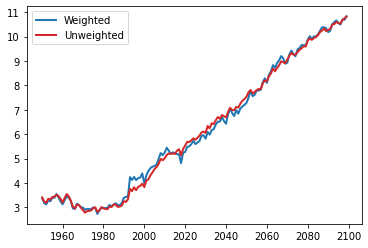

In [ ]:
import matplotlib.pyplot as plt

ds_weighted_time = ds_weighted.mean({"y", "x"}).resample(time="AS").mean()
ds_unweighted_time = ds_unweighted.mean({"y", "x"}).resample(time="AS").mean()
ens_time = ens.mean({"y", "x"}).resample(time="AS").mean()

fig, ax = plt.subplots()
var_name = "tos"

for realization in ens.realization.values:
    ax.plot(
        ens_time.time.values,
        ens_time[f"{var_name}_mean"].sel(realization=realization),
        linewidth=0.5,
        color="tab:gray",
        alpha=0.5,
        label=f"{realization}",
    )

ax.plot(
    ds_weighted_time.time.values,
    ds_weighted_time[f"{var_name}_mean"],
    linewidth=2,
    color="tab:blue",
    label="Weighted",
)

ax.plot(
    ds_unweighted_time.time.values,
    ds_unweighted_time[f"{var_name}_mean"],
    linewidth=2,
    color="tab:red",
    label="Unweighted",
)

ax.legend()

In [ ]:
ens

NameError: name 'ens' is not defined

In [ ]:
diff = ds_weighted.tos_mean - ds_unweighted.tos_mean

In [ ]:
diff

<xarray.DataArray 'tos_mean' (time: 1800, y: 10, x: 30)>
array([[[-0.08647655, -0.07553323, -0.06101638, ...,         nan,
                 nan,  0.3220109 ],
        [-0.1357046 , -0.07617115, -0.04950593, ...,  0.18806349,
          0.15579953,  0.1439226 ],
        [-0.1106429 , -0.07291185, -0.01821579, ...,  0.20405569,
          0.17074032,  0.16480942],
        ...,
        [ 0.05216916,  0.05061196,  0.11206146, ..., -0.20358591,
         -0.20924207, -0.21144513],
        [-0.00188761, -0.04554738, -0.01529973, ..., -0.29351763,
         -0.27114297, -0.23802887],
        [ 0.04160495,  0.007289  , -0.04263587, ..., -0.11766947,
         -0.1157165 , -0.10889006]],

       [[-0.11248851, -0.05732393, -0.04680758, ...,         nan,
                 nan,  0.30645666],
        [-0.13772152, -0.06285939, -0.02423937, ...,  0.19653924,
          0.170504  ,  0.13161085],
        [-0.0885515 , -0.0582923 , -0.01666215, ...,  0.19879161,
          0.12101476,  0.12094031],
...
        [ 0.00540866, -0.00044839, -0.01031124, ..., -0.07991471,
         -0.06061393, -0.035316  ],
        [ 0.10884242,  0.10589406,  0.10119053, ...,  0.05900788,
          0.09708928,  0.11774996],
        [ 0.10238992,  0.1211538 ,  0.10860584, ...,  0.11037741,
          0.10209682,  0.08680593]],

       [[ 0.00177812, -0.00303331, -0.00885254, ...,  0.        ,
          0.        ,  0.27349365],
        [-0.02887568, -0.00416979,  0.00508425, ...,  0.03448791,
          0.10816385,  0.14642832],
        [-0.01924632,  0.0021909 ,  0.01698176, ..., -0.00204803,
          0.04675263,  0.08106913],
        ...,
        [ 0.02452135,  0.00773607,  0.00169105, ..., -0.04432504,
         -0.04849854, -0.04552949],
        [ 0.0795499 ,  0.08231885,  0.07574958, ...,  0.08820008,
          0.11263258,  0.10666752],
        [-0.02012313,  0.04196216,  0.07536066, ...,  0.0971142 ,
          0.10201005,  0.08444271]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2099-12-01
    lon      (y, x) float64 5.5 6.5 7.5 8.5 9.5 ... 30.5 31.5 32.5 33.5 34.5
    lat      (y, x) float64 69.5 69.5 69.5 69.5 69.5 ... 78.5 78.5 78.5 78.5
Dimensions without coordinates: y, x

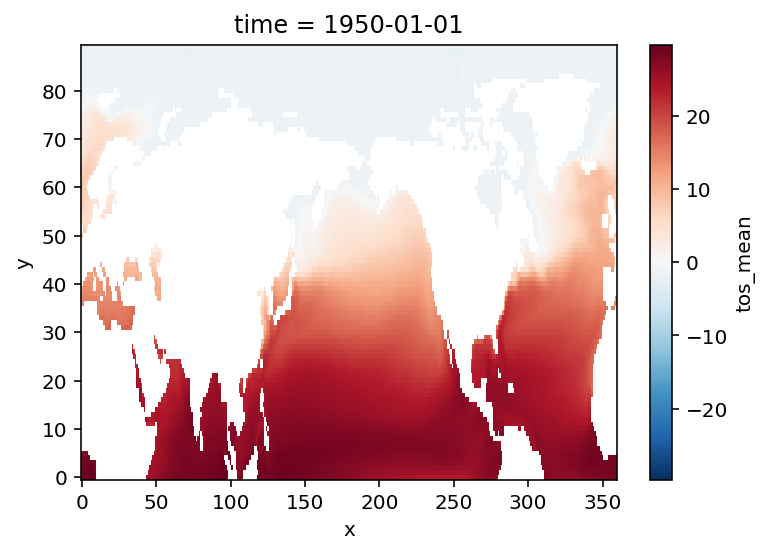

In [ ]:
ds_unweighted.tos_mean.isel(time=0).plot()